In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import glob
import os

interesting_files = glob.glob("../data/lzbench/cuda01/silesia/*.csv")
illegal_file = "../data/lzbench/cuda01/silesia/cuda01_lzbench_nvcomp_all.csv"

name = "tab20"
cmap = mpl.colormaps[name]  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

if illegal_file in interesting_files:
    interesting_files.remove(illegal_file)
    
def fix_chunk_size(data):
    """ Convert the parameter to bitshifted chunk size """
    return (abs(data)+6).apply(lambda x: 1 << int(x))

def fix_compression_ratio(data):
    """ Convert compression percentage to compression ratio """
    return 100/data


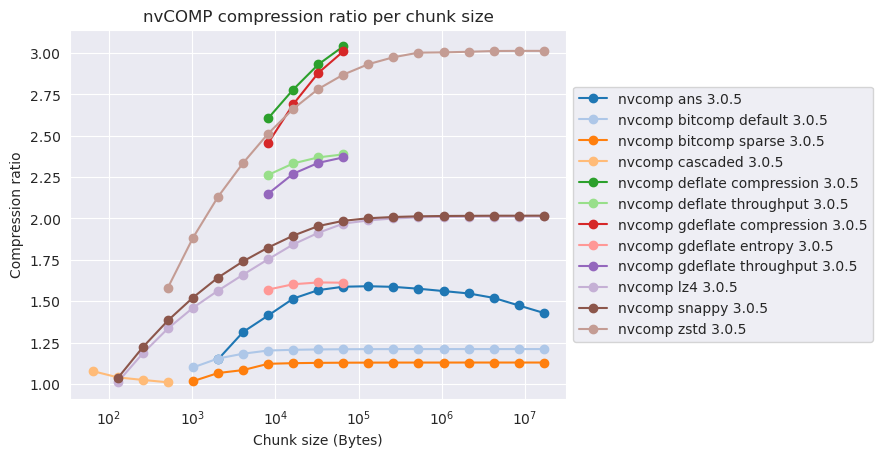

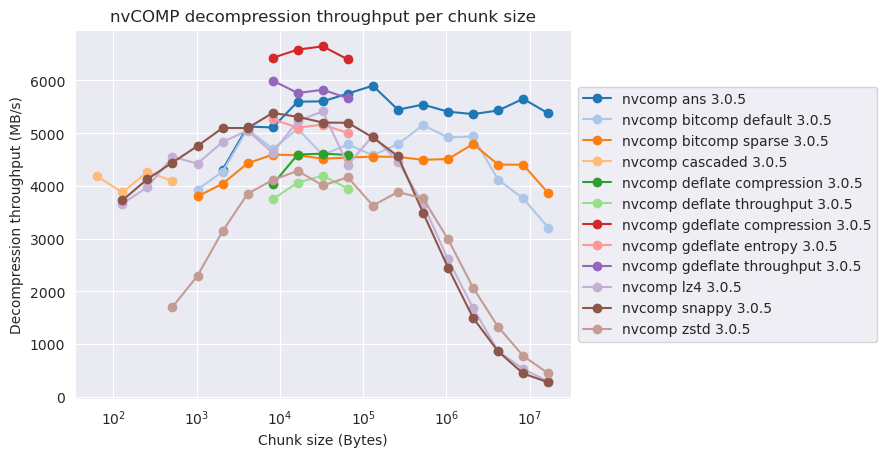

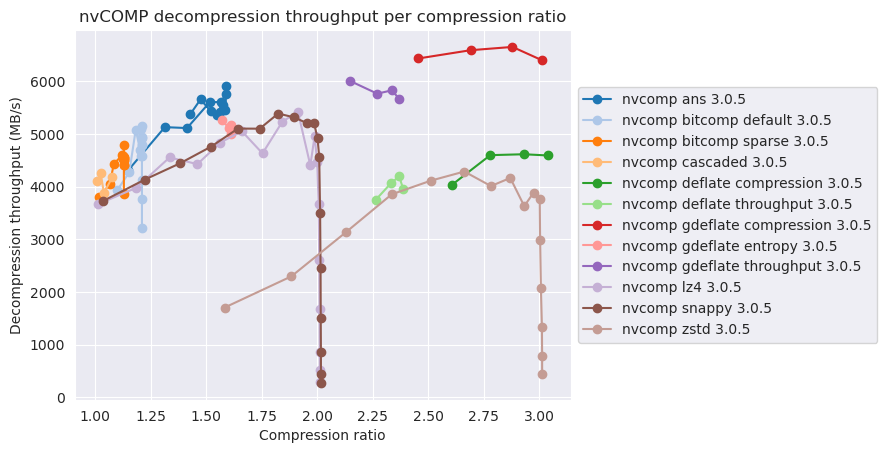

In [16]:
fig_ratio_chunksize, ax_ratio_chunksize = plt.subplots()
fig_decomp_chunksize, ax_decomp_chunksize = plt.subplots()
fig_decomp_ratio, ax_decomp_ratio = plt.subplots()

ax_ratio_chunksize.set_prop_cycle(color=colors)
ax_decomp_chunksize.set_prop_cycle(color=colors)
ax_decomp_ratio.set_prop_cycle(color=colors)



for file in interesting_files:
    df = pd.read_csv(file)
    # Remove memcpy rows
    mask = df['Compressor name'].str.contains('memcpy')
    df = df[~mask]
    
    chunk_sizes = fix_chunk_size(df['Chunk size'])
    ratio = fix_compression_ratio(df['Ratio'])
    label = df['Compressor name'][2].replace('_', ' ')
    
    ax_ratio_chunksize.plot(chunk_sizes, ratio, marker='o', label=label)
    
    decomp = df['Decompression speed']    
    ax_decomp_chunksize.plot(chunk_sizes, decomp, marker='o', label=label)
    
    ax_decomp_ratio.plot(ratio, decomp, marker='o', label=label)
    
ax_ratio_chunksize.set_xlabel('Chunk size (Bytes)')  
ax_ratio_chunksize.set_ylabel('Compression ratio') 
ax_ratio_chunksize.set_xscale('log')
ax_ratio_chunksize.set_title('nvCOMP compression ratio per chunk size')
ax_ratio_chunksize.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_ratio_chunksize.grid(True)

ax_decomp_chunksize.set_xlabel('Chunk size (Bytes)')  
ax_decomp_chunksize.set_ylabel('Decompression throughput (MB/s)') 
ax_decomp_chunksize.set_xscale('log')
ax_decomp_chunksize.set_title('nvCOMP decompression throughput per chunk size')
ax_decomp_chunksize.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_decomp_chunksize.grid(True)

ax_decomp_ratio.set_xlabel('Compression ratio')  
ax_decomp_ratio.set_ylabel('Decompression throughput (MB/s)') 
ax_decomp_ratio.set_title('nvCOMP decompression throughput per compression ratio')
ax_decomp_ratio.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_decomp_ratio.grid(True)



fig_ratio_chunksize.savefig('nvcomp-ratio-chunksizes.svg')
fig_decomp_chunksize.savefig('nvcomp-decomp-chunksizes.svg')
fig_decomp_ratio.savefig('nvcomp-decomp-ratio.svg')
